# Mask R-CNN - Inspect Custom Training Data

Inspect and visualize data loading and pre-processing code.

In [6]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import custom

%matplotlib inline 

In [7]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import custom

%matplotlib inline 

## Configurations

Configurations are defined in balloon.py

In [8]:
config = custom.CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "customImages")
print(CUSTOM_DIR)

C:\Users\yy\Downloads\car3\customImages


## Dataset

In [9]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = custom.CustomDataset()
dataset.load_custom(CUSTOM_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 160
Class Count: 5
  0. BG                                                
  1. scratch                                           
  2. dent                                              
  3. shatter                                           
  4. dislocation                                       


## Display Samples

Load and display images and masks.

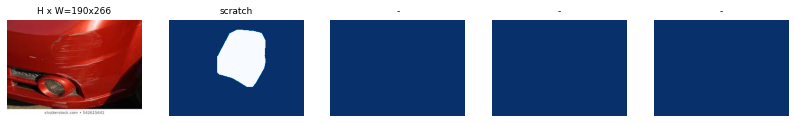

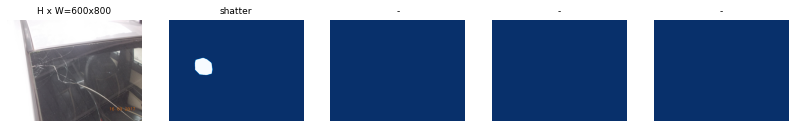

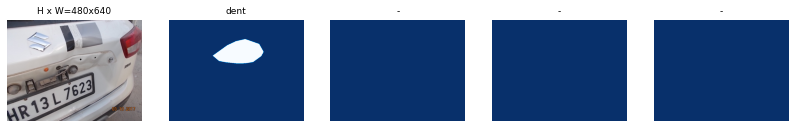

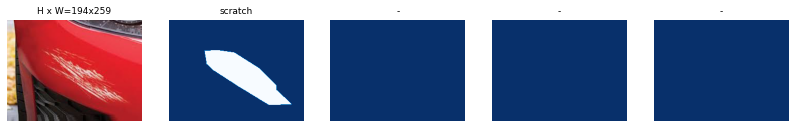

In [5]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

image_id  143 C:\Users\yy\Downloads\car3\customImages\train\144.jpg
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (480, 640, 1)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (1,)                  min:    4.00000  max:    4.00000  int32
bbox                     shape: (1, 4)                min:  100.00000  max:  453.00000  int32


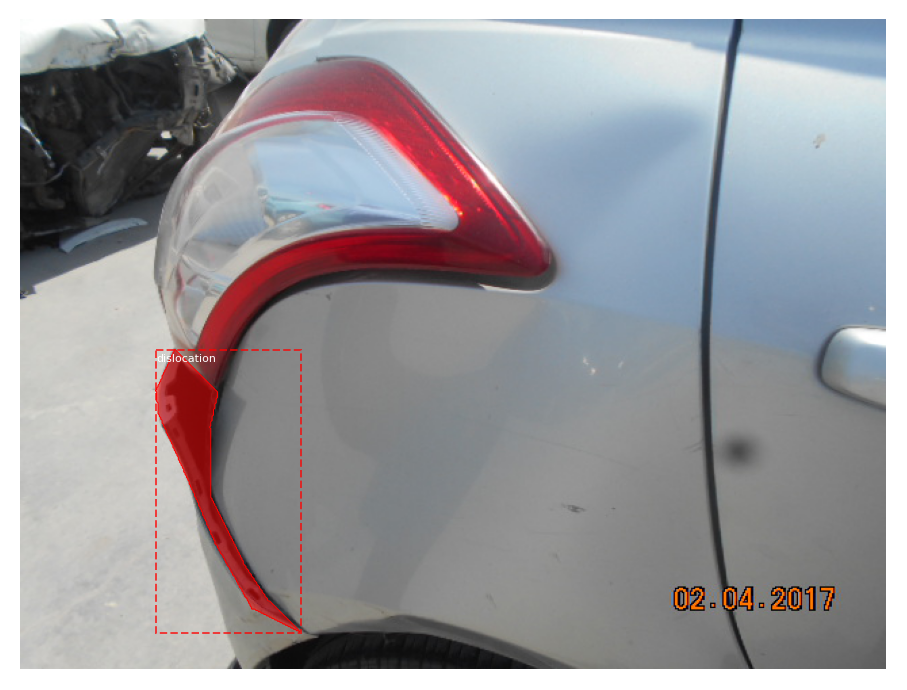

In [10]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

image_id:  99 C:\Users\yy\Downloads\car3\customImages\train\100.jpg
Original shape:  (170, 296, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  uint8
class_ids                shape: (2,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (2, 4)                min:  495.00000  max:  817.00000  int32


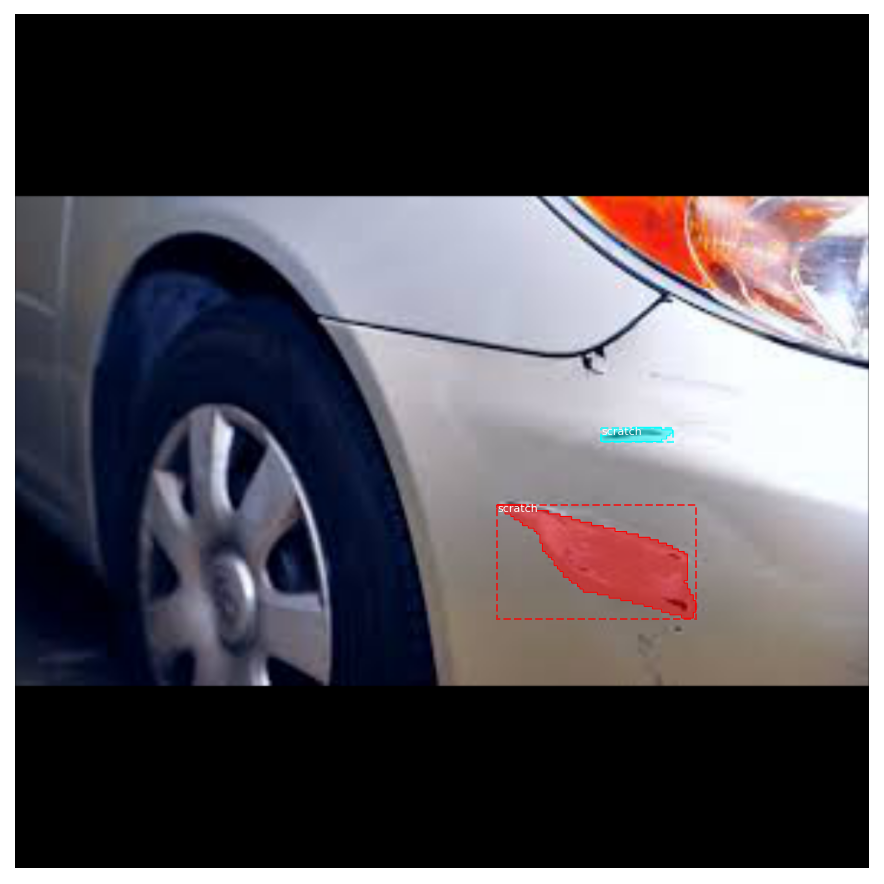

In [11]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks by:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max: 1024.00000  float64
class_ids                shape: (2,)                  min:    2.00000  max:    2.00000  int32
bbox                     shape: (2, 4)                min:  288.00000  max:  776.00000  int32
mask                     shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  uint8


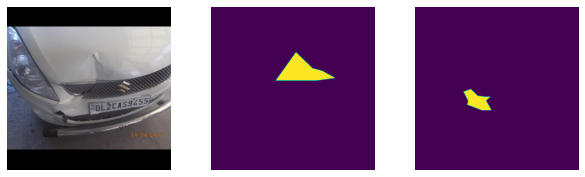

In [12]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

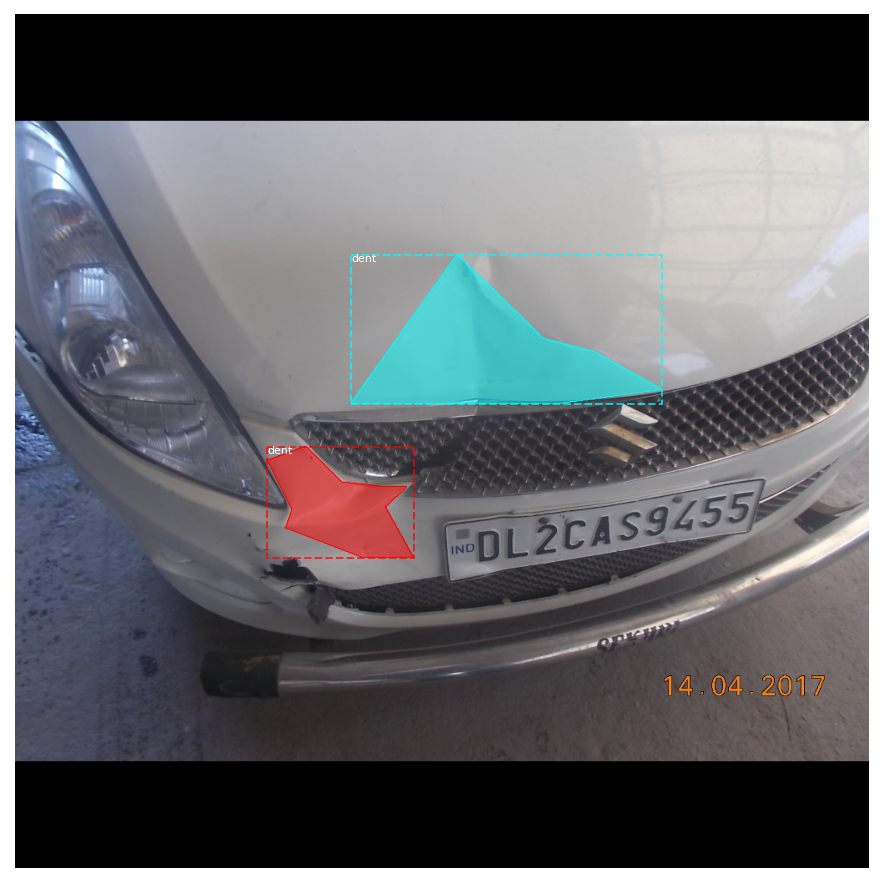

In [13]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 2)           min:    0.00000  max:    1.00000  bool


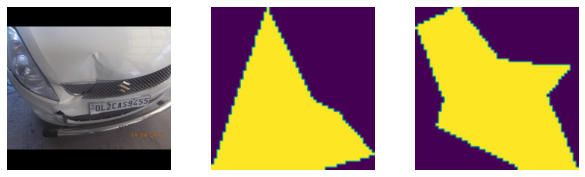

In [14]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

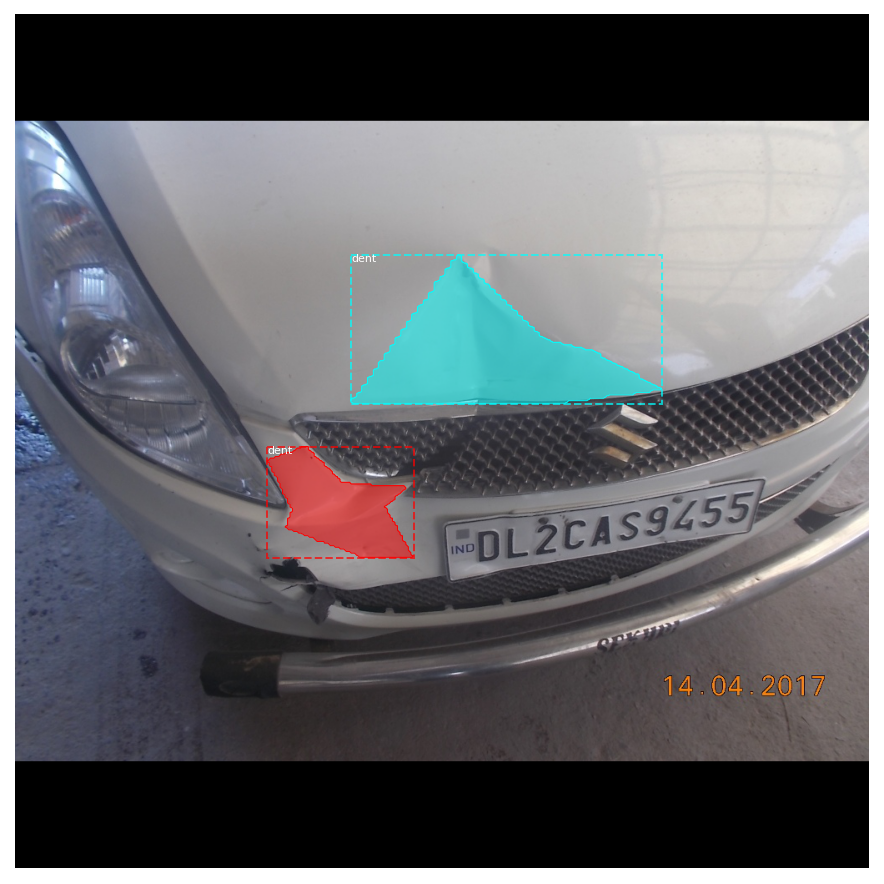

In [15]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:**
In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature meap of the first layer is 256x256, which generates about 200K anchors (256*256*3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example. 

In this implementation we use an anchor stride of 2, which is different from the paper.

In [16]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


Visualize anchors of one cell at the center of the feature map of a specific level.

Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


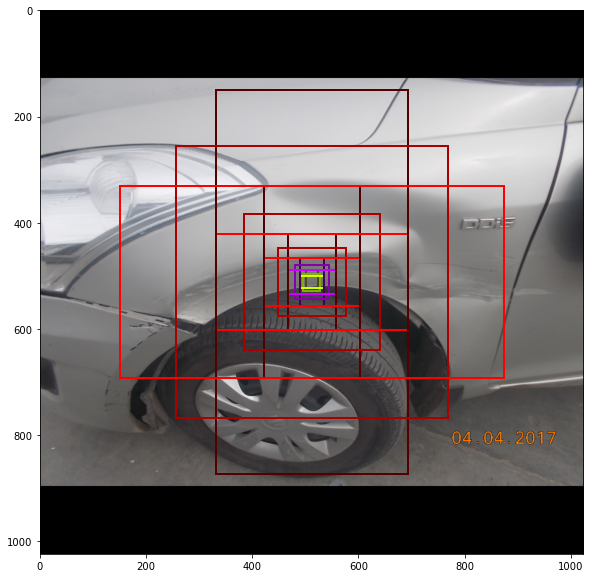

In [17]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator


In [15]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [16]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
for i in range(1000):
    print(i)
    _, _ = next(g)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [17]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 200, 4)           min:    0.00000  max: 1023.00000  int32
mrcnn_class_ids          shape: (4, 200, 1)           min:    0.00000  max:    3.00000  int32
mrcnn_bbox               shape: (4, 200, 5, 4)        min:   -2.89199  max:    3.43750  float32
mrcnn_mask               shape: (4, 200, 28, 28, 5)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    3.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  825.00000  int32
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 261888, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -3.01073  max:    2.70595  float64
image_id:  125 C:\Users\yy\Downloads\car3\customImages\train\126.jpg


anchors                  shape: (261888, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (10, 4)               min:  150.00000  max:  825.00000  float32
Positive anchors: 10
Negative anchors: 246
Neutral anchors: 261632
BG                     : 175
shatter                : 25


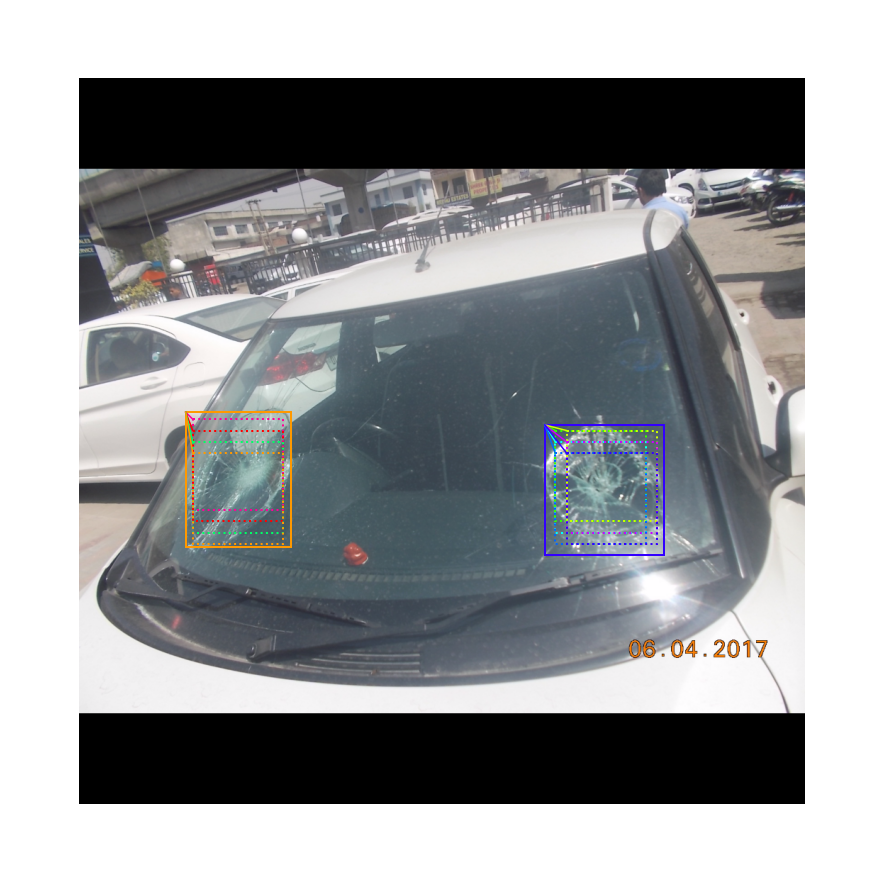

In [18]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

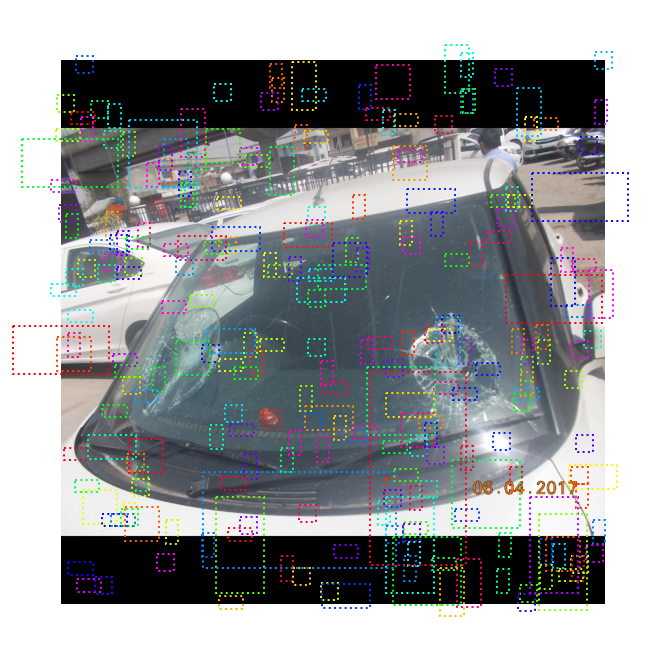

In [19]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

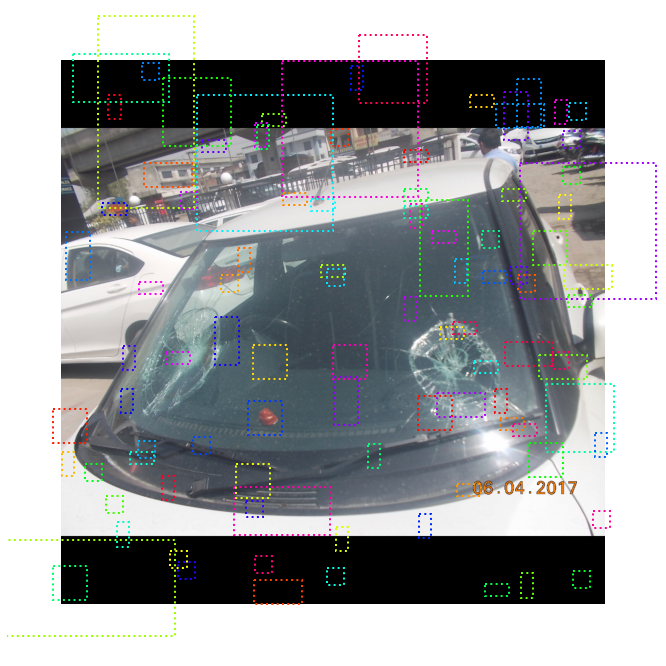

In [20]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  25
Negative ROIs:  175
Positive Ratio: 0.12
Unique ROIs: 200 out of 200


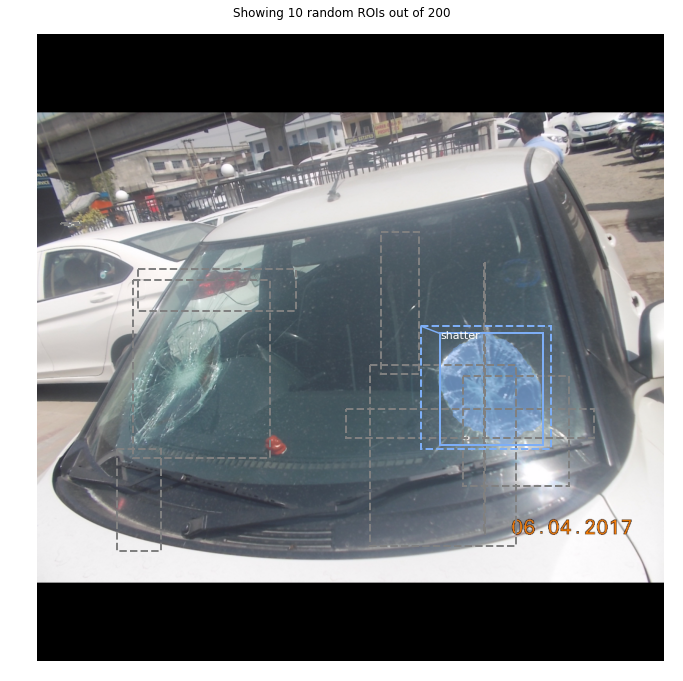

In [21]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

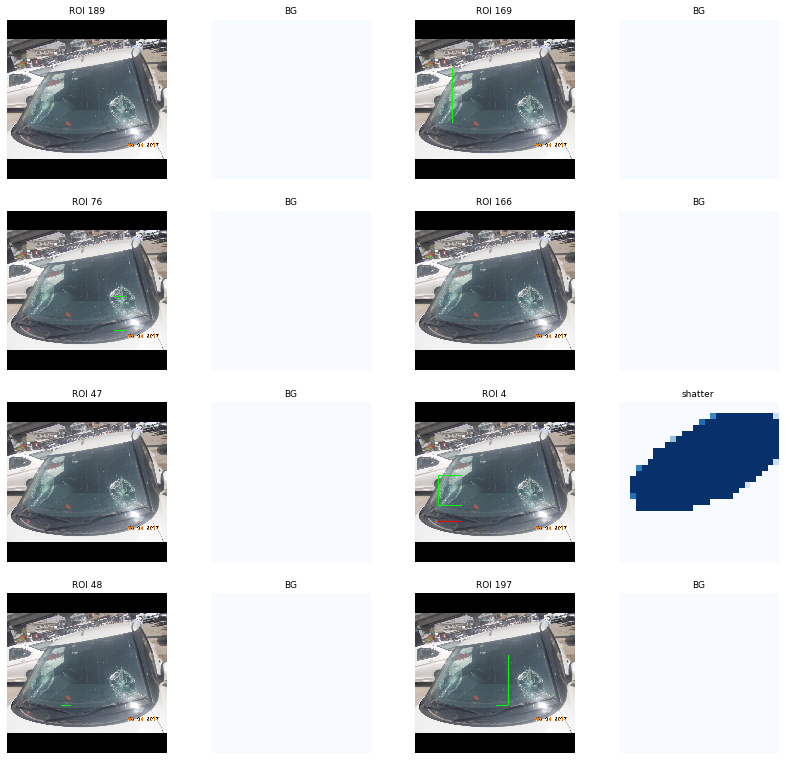

In [22]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [23]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33


In [19]:
# import basic libraries
import os
from os import listdir
import sys
import json
import datetime

# import advance libraries
from xml.etree import ElementTree
import skimage.draw
import cv2
import imgaug

# import mask rcnn libraries
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn import visualize

# import matplotlib library
import matplotlib.pyplot as plt

# import numpy libraries
import numpy as np
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean

# import keras libraries
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [26]:
# !pip install imgaug
from imgaug import augmenters as iaa



In [ ]:
class DamageDataset(Dataset):

    def load_dataset(self, dataset_dir, subset):
        
        # we use add_class for each class in our dataset and assign numbers to them. 0 is background
        # self.add_class('source', 'class id', 'class name')
        self.add_class("damage", 1, "Scratch")
        self.add_class("damage", 2, "Dent")
        self.add_class("damage", 3, "Shatter")
        self.add_class("damage", 4, "Dislocation")
        
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        
        # load annotations using json.load()
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_project.json")))
        
        # convert annotations1 into a list
        annotations = list(annotations1.values())  
        
        # we only require the regions in the annotations
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            
            # extracting shape attributes and region attributes
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['damage'] for s in a['regions']]
            
            # create a dictionary {name_of_class: class_id} remember background has id 0
            name_dict = {"Scratch": 1, "Dent": 2, "Shatter": 3, "Dislocation": 4}
            
            # all the ids/classes in a image
            num_ids = [name_dict[a] for a in objects]
            
            # you can print these ids
            # print("numids",num_ids)
            
            # read image and get height and width
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            
            # add image to the dataset
            self.add_image(
                "damage",
                image_id=a['filename'],
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )
            
    # this function calls on the extract_boxes method and is used to load a mask for each instance in an image
    # returns a boolean mask with following dimensions width * height * instances
    def load_mask(self, image_id):
        
        # info points to the current image_id
        info = self.image_info[image_id]
        
        # for cases when source is not damage
        if info["source"] != "damage":
            return super(self.__class__, self).load_mask(image_id)
        
        # get the class ids in an image
        num_ids = info['num_ids']
        
        
        
        # we create len(info["polygons"])(total number of polygons) number of masks of height 'h' and width 'w'
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
        # we loop over all polygons and generate masks (polygon mask) and class id for each instance
        # masks can have any shape as we have used polygon for annotations
        # for example: if 2.jpg have four objects we will have following masks and class_ids
        # 000001100 000111000 000001110
        # 000111100 011100000 000001110
        # 000011111 011111000 000001110
        # 000000000 111100000 000000000
        #    1         2          3    <- class_ids
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

            mask[rr, cc, i] = 1
            
        # return masks and class_ids as array
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids
    
    # this functions takes the image_id and returns the path of the image
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "damage":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

# define a configuration for the model
class DamageConfig(Config):
    # define the name of the configuration
    NAME = "damage"
    
    # number of classes (background + damge classes)
    NUM_CLASSES = 1 + 4
    
    # number of training steps per epoch
    STEPS_PER_EPOCH = 160
    # learning rate and momentum
    LEARNING_RATE=0.001
    LEARNING_MOMENTUM = 0.8
    
    # regularization penalty
    WEIGHT_DECAY = 0.0001
    
    # image size is controlled by this parameter
    IMAGE_MIN_DIM = 512
    
    # validation steps
    VALIDATION_STEPS = 50
    
    # number of Region of Interest generated per image
    Train_ROIs_Per_Image = 200
    
    # RPN Acnhor scales and ratios to find ROI
    RPN_ANCHOR_SCALES = (16, 32, 48, 64, 128)
    RPN_ANCHOR_RATIOS = [0.5, 1, 1.5]

# prepare train dataset.
train_set = DamageDataset()
# change the dataset 
train_set.load_dataset("customImages", "train")
train_set.prepare()

# prepare validation/test dataset
test_set = DamageDataset()
test_set.load_dataset("customImages", "val")
test_set.prepare()

# load damage config
config = DamageConfig()

# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)

# load weights mscoco model weights
weights_path = 'mask_rcnn.h5'

# load the model weights
model.load_weights(weights_path, 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

# Set up data augmentation
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(rotate=(-20, 20)),
    iaa.Multiply((0.9, 1.1)),
    iaa.GaussianBlur(sigma=(0.0, 1.0))
])

# Fine-tune the model
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=10, layers='all', augmentation=augmentation)



Starting at epoch 0. LR=0.001

Checkpoint Path: ./damage20240710T0339\mask_rcnn_damage_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchNorm)



C:\Users\yy\anaconda3\envs\cars\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\yy\anaconda3\envs\cars\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\yy\anaconda3\envs\cars\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
  2/160 [..............................] - ETA: 10:46:52 - loss: 6.2489 - rpn_class_loss: 0.1473 - rpn_bbox_loss: 3.1526 - mrcnn_class_loss: 0.4979 - mrcnn_bbox_loss: 0.8138 - mrcnn_mask_loss: 1.6373

In [ ]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
from keras.optimizers import SGD, Adam, RMSprop

In [ ]:
sys.path.append(ROOT_DIR) # To find local version of the library
print(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
print(MODEL_DIR)
import car_damage

%matplotlib inline
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
print(COCO_MODEL_PATH)

In [ ]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mrcnn import utils, visualize
import mrcnn.model as modellib
from mrcnn.model import log
import custom

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to pre-trained weights (you can modify this path)
COCO_MODEL_PATH = "mask_rcnn_coco.h5"


In [ ]:
class CustomConfig(custom.CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = CustomConfig()
config.display()


In [ ]:
CUSTOM_DIR = os.path.join(ROOT_DIR, "customImages")

# Training dataset
dataset_train = custom.CustomDataset()
dataset_train.load_custom(CUSTOM_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = custom.CustomDataset()
dataset_val.load_custom(CUSTOM_DIR, "val")
dataset_val.prepare()

print("Training Images: {}\nValidation Images: {}".format(len(dataset_train.image_ids), len(dataset_val.image_ids)))


In [ ]:
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)


In [ ]:
print("Loading weights ", COCO_MODEL_PATH)
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])


In [ ]:
import os
import numpy as np
import custom
from mrcnn import model as modellib

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to COCO pre-trained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

class CustomConfig(custom.CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # Background + custom class

config = CustomConfig()
config.display()


In [ ]:
# Training dataset
dataset_train = custom.CustomDataset()
dataset_train.load_custom(CUSTOM_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = custom.CustomDataset()
dataset_val.load_custom(CUSTOM_DIR, "val")
dataset_val.prepare()

print("Training Images: {}\nValidation Images: {}".format(len(dataset_train.image_ids), len(dataset_val.image_ids)))


In [ ]:
# Create the model in training mode
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

# Load pre-trained weights, excluding certain layers
print("Loading weights ", COCO_MODEL_PATH)
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

# List all layer names to identify correct layer names
for layer in model.keras_model.layers:
    print(layer.name, layer.get_weights())

# Reinitialize the layers with mismatched shapes (adjust layer names as necessary)
try:
    model.keras_model.get_layer("mrcnn_class_logits").set_weights([
        np.random.normal(size=model.keras_model.get_layer("mrcnn_class_logits").get_weights()[0].shape),
        np.random.normal(size=model.keras_model.get_layer("mrcnn_class_logits").get_weights()[1].shape),
    ])
except IndexError:
    print("Layer mrcnn_class_logits not found or has no weights")

try:
    model.keras_model.get_layer("mrcnn_bbox_fc").set_weights([
        np.random.normal(size=model.keras_model.get_layer("mrcnn_bbox_fc").get_weights()[0].shape),
        np.random.normal(size=model.keras_model.get_layer("mrcnn_bbox_fc").get_weights()[1].shape),
    ])
except IndexError:
    print("Layer mrcnn_bbox_fc not found or has no weights")

try:
    model.keras_model.get_layer("mrcnn_bbox").set_weights([
        np.random.normal(size=model.keras_model.get_layer("mrcnn_bbox").get_weights()[0].shape),
        np.random.normal(size=model.keras_model.get_layer("mrcnn_bbox").get_weights()[1].shape),
    ])
except IndexError:
    print("Layer mrcnn_bbox not found or has no weights")

try:
    model.keras_model.get_layer("mrcnn_mask").set_weights([
        np.random.normal(size=model.keras_model.get_layer("mrcnn_mask").get_weights()[0].shape),
        np.random.normal(size=model.keras_model.get_layer("mrcnn_mask").get_weights()[1].shape),
    ])
except IndexError:
    print("Layer mrcnn_mask not found or has no weights")


In [ ]:
# Train the model
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=30,
            layers='heads')
